# Face Generation


### System Info
- CPU: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz 3.30GHz
- GPU: NVIDIA GeForce GTX 960 4GB
- Cuda: Cuda compilation tools, release 8.0, V8.0.60
- OS: Microsoft Windows 10 Pro 64-bit
- OS Version: 10.0.14393 N/A Build 14393
- Python: 3.5.4
- TensorFlow: tensorflow-gpu-1.1.0

In this project, you'll use generative adversarial networks to generate new images of faces.

### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

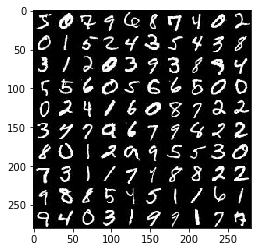

In [21]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

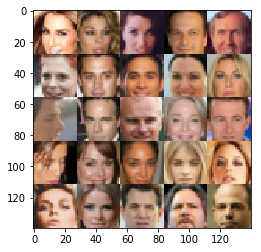

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [45]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function    
    # Leaky parameter Alpha can be changed(0.01, 0.05, 0.1...)
    alpha = 0.05
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input data dimension: 28*28*3
        # 1st conv layer conv1: 14*14
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")  
        relu1 = tf.maximum(alpha * conv1, conv1) 
        #print("relu1 is:")
        #print(relu1)
        
        # 2nd conv layer conv2: 7*7, relu2: 8*8
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2)
        
        # Flatten layer
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1, activation=None)
        #print(logits)
        
        ouput = tf.sigmoid(logits)    
        
        return ouput, logits   
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Same leaky alpha as discriminator
    alpha = 0.05
    
    with tf.variable_scope('generator', reuse=not is_train):
        # why reuse=not is_train ?
        # First fully connected layer, shape same as flat layer in discriminator
        fc = tf.layers.dense(z, 7*7*128)
        #print(fc)
        
        # Reshape it to start the conv stack 7*7
        fc = tf.reshape(fc, (-1, 7, 7, 128))
        bn1 = tf.layers.batch_normalization(fc, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #print(relu1)
        
        # DC1 shape should be 14*14
        dc1 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(dc1, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2)
        
        # Output shape should be 28*28
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
        #print("logit tensor shape:")
        #print(logits)
        
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # print(data_shape) (60000, 28, 28, 1)
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    losses = []
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescale from (-0.5, 0.5) to (-1, 1) adapted to tanh activation function
                #print(batch_images)
                batch_images = batch_images * 2
                #print(batch_images)
               
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images,inputs_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Step {}".format(steps),
                          "Epoch {}/{}".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g)
                         )
                    #losses.append(train_loss_d, train_loss_g)
                
                if steps % show_every == 0:    
                    show_generator_output(sess, 16, inputs_z, image_channels, data_image_mode)
                    
        print("Training ended.")
        
        #saver.save(sess, './checkpoints/generator.ckpt')           
    
    #with open('samples.pkl', 'wb') as f:
        #pkl.dump(samples, f)
    
    #return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10 Epoch 1/2 Discriminator Loss: 0.3789... Generator Loss: 3.0984...
Step 20 Epoch 1/2 Discriminator Loss: 4.3025... Generator Loss: 6.7671...
Step 30 Epoch 1/2 Discriminator Loss: 0.4931... Generator Loss: 1.7978...
Step 40 Epoch 1/2 Discriminator Loss: 1.6532... Generator Loss: 0.4206...
Step 50 Epoch 1/2 Discriminator Loss: 0.8688... Generator Loss: 0.9747...
Step 60 Epoch 1/2 Discriminator Loss: 1.1341... Generator Loss: 0.8883...
Step 70 Epoch 1/2 Discriminator Loss: 1.0235... Generator Loss: 0.9963...
Step 80 Epoch 1/2 Discriminator Loss: 1.2525... Generator Loss: 1.8221...
Step 90 Epoch 1/2 Discriminator Loss: 1.2743... Generator Loss: 1.2959...
Step 100 Epoch 1/2 Discriminator Loss: 1.3117... Generator Loss: 0.7338...


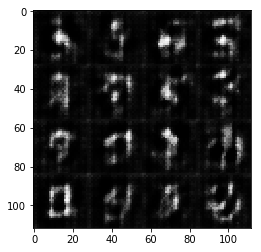

Step 110 Epoch 1/2 Discriminator Loss: 1.2994... Generator Loss: 1.3899...
Step 120 Epoch 1/2 Discriminator Loss: 1.0345... Generator Loss: 0.7876...
Step 130 Epoch 1/2 Discriminator Loss: 1.7761... Generator Loss: 0.2566...
Step 140 Epoch 1/2 Discriminator Loss: 1.3211... Generator Loss: 0.4640...
Step 150 Epoch 1/2 Discriminator Loss: 1.4397... Generator Loss: 0.4034...
Step 160 Epoch 1/2 Discriminator Loss: 1.4518... Generator Loss: 0.4629...
Step 170 Epoch 1/2 Discriminator Loss: 1.2057... Generator Loss: 0.5970...
Step 180 Epoch 1/2 Discriminator Loss: 1.1367... Generator Loss: 1.3849...
Step 190 Epoch 1/2 Discriminator Loss: 0.8534... Generator Loss: 0.8960...
Step 200 Epoch 1/2 Discriminator Loss: 0.9294... Generator Loss: 1.1074...


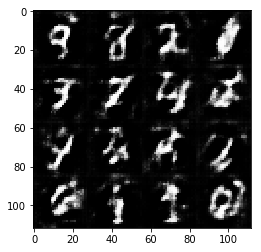

Step 210 Epoch 1/2 Discriminator Loss: 1.3384... Generator Loss: 2.0440...
Step 220 Epoch 1/2 Discriminator Loss: 0.9083... Generator Loss: 1.0695...
Step 230 Epoch 1/2 Discriminator Loss: 1.4421... Generator Loss: 0.3701...
Step 240 Epoch 1/2 Discriminator Loss: 0.9153... Generator Loss: 0.8111...
Step 250 Epoch 1/2 Discriminator Loss: 1.2384... Generator Loss: 1.8991...
Step 260 Epoch 1/2 Discriminator Loss: 0.9936... Generator Loss: 1.2564...
Step 270 Epoch 1/2 Discriminator Loss: 0.9573... Generator Loss: 1.3507...
Step 280 Epoch 1/2 Discriminator Loss: 1.3154... Generator Loss: 0.4307...
Step 290 Epoch 1/2 Discriminator Loss: 1.1135... Generator Loss: 1.1432...
Step 300 Epoch 1/2 Discriminator Loss: 1.2184... Generator Loss: 0.5443...


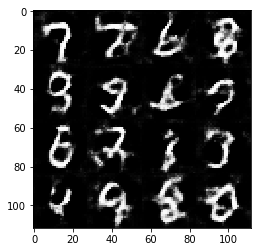

Step 310 Epoch 1/2 Discriminator Loss: 1.3927... Generator Loss: 0.3810...
Step 320 Epoch 1/2 Discriminator Loss: 1.0389... Generator Loss: 0.8154...
Step 330 Epoch 1/2 Discriminator Loss: 1.1549... Generator Loss: 0.7835...
Step 340 Epoch 1/2 Discriminator Loss: 1.2631... Generator Loss: 0.9090...
Step 350 Epoch 1/2 Discriminator Loss: 1.2644... Generator Loss: 1.6126...
Step 360 Epoch 1/2 Discriminator Loss: 1.1472... Generator Loss: 1.3507...
Step 370 Epoch 1/2 Discriminator Loss: 1.0143... Generator Loss: 0.7785...
Step 380 Epoch 1/2 Discriminator Loss: 1.5396... Generator Loss: 0.3351...
Step 390 Epoch 1/2 Discriminator Loss: 1.2287... Generator Loss: 0.6299...
Step 400 Epoch 1/2 Discriminator Loss: 1.1022... Generator Loss: 0.7422...


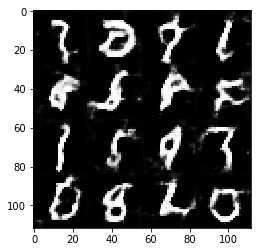

Step 410 Epoch 1/2 Discriminator Loss: 1.2927... Generator Loss: 1.8591...
Step 420 Epoch 1/2 Discriminator Loss: 1.1716... Generator Loss: 0.5625...
Step 430 Epoch 1/2 Discriminator Loss: 1.3632... Generator Loss: 1.7940...
Step 440 Epoch 1/2 Discriminator Loss: 1.1783... Generator Loss: 0.5939...
Step 450 Epoch 1/2 Discriminator Loss: 1.0215... Generator Loss: 0.9096...
Step 460 Epoch 1/2 Discriminator Loss: 1.1647... Generator Loss: 0.5798...
Step 470 Epoch 2/2 Discriminator Loss: 1.3342... Generator Loss: 0.4288...
Step 480 Epoch 2/2 Discriminator Loss: 1.0419... Generator Loss: 0.9679...
Step 490 Epoch 2/2 Discriminator Loss: 1.0481... Generator Loss: 0.7687...
Step 500 Epoch 2/2 Discriminator Loss: 1.3348... Generator Loss: 0.4852...


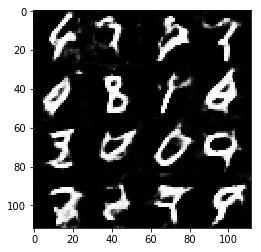

Step 510 Epoch 2/2 Discriminator Loss: 1.1015... Generator Loss: 0.6815...
Step 520 Epoch 2/2 Discriminator Loss: 1.3197... Generator Loss: 1.2913...
Step 530 Epoch 2/2 Discriminator Loss: 1.4509... Generator Loss: 0.4836...
Step 540 Epoch 2/2 Discriminator Loss: 1.1791... Generator Loss: 0.6105...
Step 550 Epoch 2/2 Discriminator Loss: 1.1221... Generator Loss: 0.7600...
Step 560 Epoch 2/2 Discriminator Loss: 1.2164... Generator Loss: 1.6321...
Step 570 Epoch 2/2 Discriminator Loss: 1.0516... Generator Loss: 0.9214...
Step 580 Epoch 2/2 Discriminator Loss: 1.0516... Generator Loss: 1.0872...
Step 590 Epoch 2/2 Discriminator Loss: 1.3907... Generator Loss: 0.4163...
Step 600 Epoch 2/2 Discriminator Loss: 1.2390... Generator Loss: 0.5460...


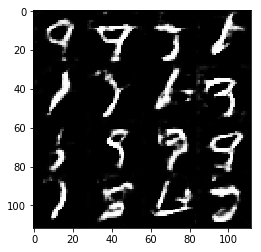

Step 610 Epoch 2/2 Discriminator Loss: 1.0756... Generator Loss: 1.1867...
Step 620 Epoch 2/2 Discriminator Loss: 1.0750... Generator Loss: 1.0167...
Step 630 Epoch 2/2 Discriminator Loss: 1.1427... Generator Loss: 1.2489...
Step 640 Epoch 2/2 Discriminator Loss: 1.1025... Generator Loss: 0.7185...
Step 650 Epoch 2/2 Discriminator Loss: 0.9762... Generator Loss: 0.9931...
Step 660 Epoch 2/2 Discriminator Loss: 2.2124... Generator Loss: 2.2140...
Step 670 Epoch 2/2 Discriminator Loss: 1.0749... Generator Loss: 0.9536...
Step 680 Epoch 2/2 Discriminator Loss: 1.0883... Generator Loss: 0.8450...
Step 690 Epoch 2/2 Discriminator Loss: 1.0079... Generator Loss: 0.9791...
Step 700 Epoch 2/2 Discriminator Loss: 1.0208... Generator Loss: 0.7697...


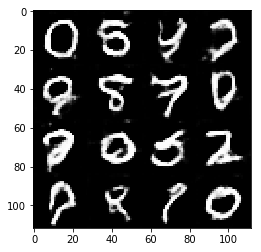

Step 710 Epoch 2/2 Discriminator Loss: 1.2845... Generator Loss: 1.5934...
Step 720 Epoch 2/2 Discriminator Loss: 0.9395... Generator Loss: 1.0394...
Step 730 Epoch 2/2 Discriminator Loss: 1.0897... Generator Loss: 1.1195...
Step 740 Epoch 2/2 Discriminator Loss: 1.0314... Generator Loss: 0.9279...
Step 750 Epoch 2/2 Discriminator Loss: 1.0514... Generator Loss: 1.1055...
Step 760 Epoch 2/2 Discriminator Loss: 1.0458... Generator Loss: 0.7971...
Step 770 Epoch 2/2 Discriminator Loss: 1.6065... Generator Loss: 2.0712...
Step 780 Epoch 2/2 Discriminator Loss: 1.1522... Generator Loss: 0.6862...
Step 790 Epoch 2/2 Discriminator Loss: 1.2326... Generator Loss: 0.4883...
Step 800 Epoch 2/2 Discriminator Loss: 1.1052... Generator Loss: 0.9226...


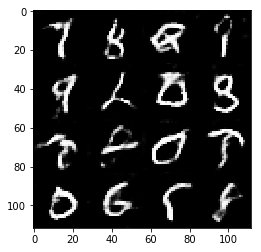

Step 810 Epoch 2/2 Discriminator Loss: 1.1770... Generator Loss: 0.6146...
Step 820 Epoch 2/2 Discriminator Loss: 0.8884... Generator Loss: 1.0471...
Step 830 Epoch 2/2 Discriminator Loss: 0.9324... Generator Loss: 1.2652...
Step 840 Epoch 2/2 Discriminator Loss: 0.9723... Generator Loss: 1.1198...
Step 850 Epoch 2/2 Discriminator Loss: 1.6004... Generator Loss: 0.3143...
Step 860 Epoch 2/2 Discriminator Loss: 1.1000... Generator Loss: 0.7039...
Step 870 Epoch 2/2 Discriminator Loss: 1.1957... Generator Loss: 0.5112...
Step 880 Epoch 2/2 Discriminator Loss: 0.8978... Generator Loss: 1.0390...
Step 890 Epoch 2/2 Discriminator Loss: 1.0612... Generator Loss: 1.4370...
Step 900 Epoch 2/2 Discriminator Loss: 1.2126... Generator Loss: 0.5377...


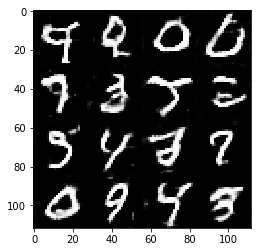

Step 910 Epoch 2/2 Discriminator Loss: 1.5406... Generator Loss: 0.3683...
Step 920 Epoch 2/2 Discriminator Loss: 1.0976... Generator Loss: 1.5603...
Step 930 Epoch 2/2 Discriminator Loss: 0.8600... Generator Loss: 0.9479...
Training ended.


In [43]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.5
print_every = 10
show_every = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10 Epoch 1/1 Discriminator Loss: 1.2062... Generator Loss: 0.4847...
Step 20 Epoch 1/1 Discriminator Loss: 0.2275... Generator Loss: 8.1237...
Step 30 Epoch 1/1 Discriminator Loss: 0.4679... Generator Loss: 1.7933...
Step 40 Epoch 1/1 Discriminator Loss: 1.6557... Generator Loss: 3.9382...
Step 50 Epoch 1/1 Discriminator Loss: 1.1319... Generator Loss: 0.6508...
Step 60 Epoch 1/1 Discriminator Loss: 1.0770... Generator Loss: 0.7514...
Step 70 Epoch 1/1 Discriminator Loss: 1.3320... Generator Loss: 2.6982...
Step 80 Epoch 1/1 Discriminator Loss: 0.7811... Generator Loss: 3.8752...
Step 90 Epoch 1/1 Discriminator Loss: 2.7923... Generator Loss: 7.9766...
Step 100 Epoch 1/1 Discriminator Loss: 0.8659... Generator Loss: 0.8355...


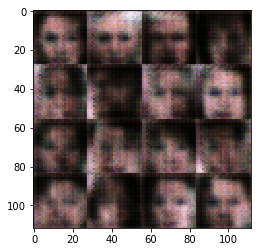

Step 110 Epoch 1/1 Discriminator Loss: 1.0733... Generator Loss: 0.6368...
Step 120 Epoch 1/1 Discriminator Loss: 0.8843... Generator Loss: 0.8358...
Step 130 Epoch 1/1 Discriminator Loss: 0.5582... Generator Loss: 4.0065...
Step 140 Epoch 1/1 Discriminator Loss: 0.2129... Generator Loss: 2.2417...
Step 150 Epoch 1/1 Discriminator Loss: 0.1609... Generator Loss: 2.5035...
Step 160 Epoch 1/1 Discriminator Loss: 1.7188... Generator Loss: 0.3094...
Step 170 Epoch 1/1 Discriminator Loss: 0.8960... Generator Loss: 2.7123...
Step 180 Epoch 1/1 Discriminator Loss: 2.0141... Generator Loss: 3.9788...
Step 190 Epoch 1/1 Discriminator Loss: 0.5861... Generator Loss: 1.5701...
Step 200 Epoch 1/1 Discriminator Loss: 0.9353... Generator Loss: 1.4672...


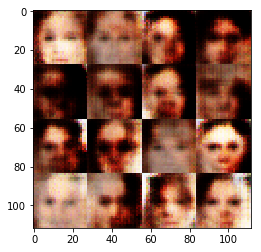

Step 210 Epoch 1/1 Discriminator Loss: 2.1625... Generator Loss: 0.1640...
Step 220 Epoch 1/1 Discriminator Loss: 0.6277... Generator Loss: 1.3012...
Step 230 Epoch 1/1 Discriminator Loss: 0.6779... Generator Loss: 1.8080...
Step 240 Epoch 1/1 Discriminator Loss: 2.0713... Generator Loss: 2.1927...
Step 250 Epoch 1/1 Discriminator Loss: 1.0117... Generator Loss: 0.7814...
Step 260 Epoch 1/1 Discriminator Loss: 0.9727... Generator Loss: 1.0837...
Step 270 Epoch 1/1 Discriminator Loss: 0.6896... Generator Loss: 1.4613...
Step 280 Epoch 1/1 Discriminator Loss: 1.4282... Generator Loss: 0.4592...
Step 290 Epoch 1/1 Discriminator Loss: 1.0181... Generator Loss: 1.4203...
Step 300 Epoch 1/1 Discriminator Loss: 1.3172... Generator Loss: 1.6738...


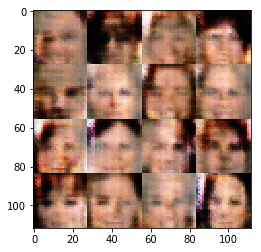

Step 310 Epoch 1/1 Discriminator Loss: 0.6388... Generator Loss: 1.8131...
Step 320 Epoch 1/1 Discriminator Loss: 1.2496... Generator Loss: 4.1312...
Step 330 Epoch 1/1 Discriminator Loss: 0.4540... Generator Loss: 2.0354...
Step 340 Epoch 1/1 Discriminator Loss: 1.2242... Generator Loss: 2.3187...
Step 350 Epoch 1/1 Discriminator Loss: 2.3656... Generator Loss: 0.1330...
Step 360 Epoch 1/1 Discriminator Loss: 0.5648... Generator Loss: 2.4260...
Step 370 Epoch 1/1 Discriminator Loss: 1.0646... Generator Loss: 0.6588...
Step 380 Epoch 1/1 Discriminator Loss: 0.9701... Generator Loss: 0.7128...
Step 390 Epoch 1/1 Discriminator Loss: 1.1791... Generator Loss: 0.5978...
Step 400 Epoch 1/1 Discriminator Loss: 1.3784... Generator Loss: 0.9148...


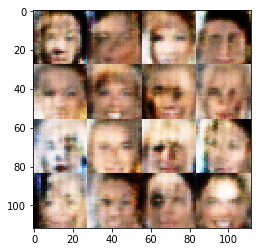

Step 410 Epoch 1/1 Discriminator Loss: 1.0239... Generator Loss: 2.2459...
Step 420 Epoch 1/1 Discriminator Loss: 1.2576... Generator Loss: 0.5024...
Step 430 Epoch 1/1 Discriminator Loss: 1.3453... Generator Loss: 0.5249...
Step 440 Epoch 1/1 Discriminator Loss: 1.1151... Generator Loss: 0.5994...
Step 450 Epoch 1/1 Discriminator Loss: 1.1080... Generator Loss: 0.6379...
Step 460 Epoch 1/1 Discriminator Loss: 1.3346... Generator Loss: 1.2500...
Step 470 Epoch 1/1 Discriminator Loss: 0.4606... Generator Loss: 1.9408...
Step 480 Epoch 1/1 Discriminator Loss: 1.6054... Generator Loss: 0.8691...
Step 490 Epoch 1/1 Discriminator Loss: 0.7932... Generator Loss: 1.6729...
Step 500 Epoch 1/1 Discriminator Loss: 0.9304... Generator Loss: 2.1996...


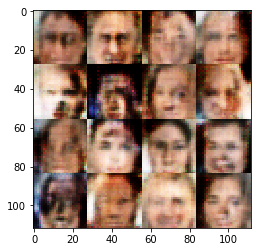

Step 510 Epoch 1/1 Discriminator Loss: 1.5665... Generator Loss: 2.2670...
Step 520 Epoch 1/1 Discriminator Loss: 0.7633... Generator Loss: 0.8082...
Step 530 Epoch 1/1 Discriminator Loss: 1.5598... Generator Loss: 1.3654...
Step 540 Epoch 1/1 Discriminator Loss: 1.6321... Generator Loss: 1.6153...
Step 550 Epoch 1/1 Discriminator Loss: 1.2333... Generator Loss: 0.8450...
Step 560 Epoch 1/1 Discriminator Loss: 1.1670... Generator Loss: 0.6296...
Step 570 Epoch 1/1 Discriminator Loss: 0.9654... Generator Loss: 1.1701...
Step 580 Epoch 1/1 Discriminator Loss: 2.0686... Generator Loss: 0.1725...
Step 590 Epoch 1/1 Discriminator Loss: 1.1631... Generator Loss: 0.9289...
Step 600 Epoch 1/1 Discriminator Loss: 2.3822... Generator Loss: 3.2798...


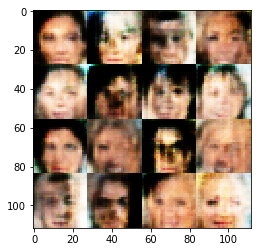

Step 610 Epoch 1/1 Discriminator Loss: 1.3844... Generator Loss: 1.5358...
Step 620 Epoch 1/1 Discriminator Loss: 1.2771... Generator Loss: 0.4509...
Step 630 Epoch 1/1 Discriminator Loss: 1.4310... Generator Loss: 0.3750...
Step 640 Epoch 1/1 Discriminator Loss: 1.1344... Generator Loss: 0.9026...
Step 650 Epoch 1/1 Discriminator Loss: 1.5643... Generator Loss: 2.2899...
Step 660 Epoch 1/1 Discriminator Loss: 0.7114... Generator Loss: 2.1475...
Step 670 Epoch 1/1 Discriminator Loss: 1.0940... Generator Loss: 0.6334...
Step 680 Epoch 1/1 Discriminator Loss: 0.8612... Generator Loss: 1.4362...
Step 690 Epoch 1/1 Discriminator Loss: 1.2368... Generator Loss: 0.7164...
Step 700 Epoch 1/1 Discriminator Loss: 1.2353... Generator Loss: 0.9001...


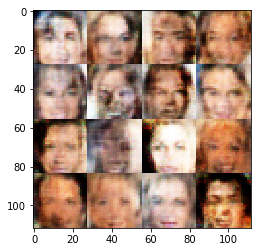

Step 710 Epoch 1/1 Discriminator Loss: 0.7055... Generator Loss: 1.6274...
Step 720 Epoch 1/1 Discriminator Loss: 1.4421... Generator Loss: 0.3921...
Step 730 Epoch 1/1 Discriminator Loss: 1.2853... Generator Loss: 0.8069...
Step 740 Epoch 1/1 Discriminator Loss: 1.2144... Generator Loss: 0.6936...
Step 750 Epoch 1/1 Discriminator Loss: 1.0069... Generator Loss: 0.5885...
Step 760 Epoch 1/1 Discriminator Loss: 1.2422... Generator Loss: 0.9193...
Step 770 Epoch 1/1 Discriminator Loss: 1.5926... Generator Loss: 0.4447...
Step 780 Epoch 1/1 Discriminator Loss: 1.3932... Generator Loss: 1.1257...
Step 790 Epoch 1/1 Discriminator Loss: 1.3366... Generator Loss: 0.5474...
Step 800 Epoch 1/1 Discriminator Loss: 1.1731... Generator Loss: 0.7580...


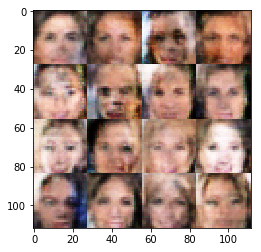

Step 810 Epoch 1/1 Discriminator Loss: 1.3109... Generator Loss: 0.7095...
Step 820 Epoch 1/1 Discriminator Loss: 1.2705... Generator Loss: 0.5684...
Step 830 Epoch 1/1 Discriminator Loss: 1.3212... Generator Loss: 0.8834...
Step 840 Epoch 1/1 Discriminator Loss: 1.2163... Generator Loss: 0.5198...
Step 850 Epoch 1/1 Discriminator Loss: 1.6175... Generator Loss: 1.3997...
Step 860 Epoch 1/1 Discriminator Loss: 1.4539... Generator Loss: 0.9590...
Step 870 Epoch 1/1 Discriminator Loss: 1.3257... Generator Loss: 0.5617...
Step 880 Epoch 1/1 Discriminator Loss: 1.4210... Generator Loss: 1.0083...
Step 890 Epoch 1/1 Discriminator Loss: 1.2882... Generator Loss: 0.7907...
Step 900 Epoch 1/1 Discriminator Loss: 2.1031... Generator Loss: 0.1753...


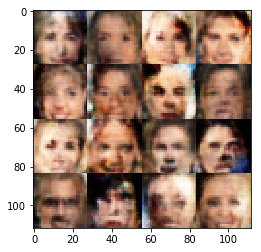

Step 910 Epoch 1/1 Discriminator Loss: 1.3491... Generator Loss: 0.5219...
Step 920 Epoch 1/1 Discriminator Loss: 1.1715... Generator Loss: 0.9769...
Step 930 Epoch 1/1 Discriminator Loss: 1.3264... Generator Loss: 0.5912...
Step 940 Epoch 1/1 Discriminator Loss: 1.5891... Generator Loss: 0.3216...
Step 950 Epoch 1/1 Discriminator Loss: 1.2063... Generator Loss: 0.5724...
Step 960 Epoch 1/1 Discriminator Loss: 1.2287... Generator Loss: 0.7909...
Step 970 Epoch 1/1 Discriminator Loss: 1.2939... Generator Loss: 0.8461...
Step 980 Epoch 1/1 Discriminator Loss: 1.6250... Generator Loss: 0.8475...
Step 990 Epoch 1/1 Discriminator Loss: 1.3209... Generator Loss: 0.5365...
Step 1000 Epoch 1/1 Discriminator Loss: 1.0636... Generator Loss: 1.0924...


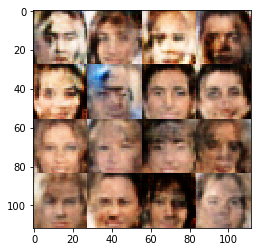

Step 1010 Epoch 1/1 Discriminator Loss: 1.2046... Generator Loss: 0.5387...
Step 1020 Epoch 1/1 Discriminator Loss: 1.4834... Generator Loss: 0.3522...
Step 1030 Epoch 1/1 Discriminator Loss: 1.6188... Generator Loss: 1.6526...
Step 1040 Epoch 1/1 Discriminator Loss: 0.5138... Generator Loss: 1.4416...
Step 1050 Epoch 1/1 Discriminator Loss: 1.2037... Generator Loss: 0.5858...
Step 1060 Epoch 1/1 Discriminator Loss: 1.0838... Generator Loss: 1.0125...
Step 1070 Epoch 1/1 Discriminator Loss: 1.2818... Generator Loss: 0.7018...
Step 1080 Epoch 1/1 Discriminator Loss: 1.3149... Generator Loss: 0.5491...
Step 1090 Epoch 1/1 Discriminator Loss: 1.5834... Generator Loss: 0.2918...
Step 1100 Epoch 1/1 Discriminator Loss: 1.4124... Generator Loss: 0.4465...


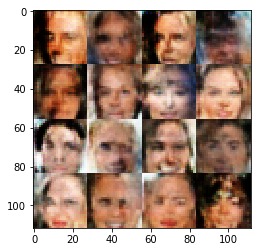

Step 1110 Epoch 1/1 Discriminator Loss: 2.5013... Generator Loss: 0.1218...
Step 1120 Epoch 1/1 Discriminator Loss: 1.3347... Generator Loss: 0.9624...
Step 1130 Epoch 1/1 Discriminator Loss: 0.7828... Generator Loss: 2.5443...
Step 1140 Epoch 1/1 Discriminator Loss: 1.1168... Generator Loss: 1.0573...
Step 1150 Epoch 1/1 Discriminator Loss: 1.1485... Generator Loss: 1.1442...
Step 1160 Epoch 1/1 Discriminator Loss: 1.3343... Generator Loss: 1.2769...
Step 1170 Epoch 1/1 Discriminator Loss: 1.1773... Generator Loss: 0.8562...
Step 1180 Epoch 1/1 Discriminator Loss: 1.3012... Generator Loss: 0.5727...
Step 1190 Epoch 1/1 Discriminator Loss: 1.1811... Generator Loss: 0.8719...
Step 1200 Epoch 1/1 Discriminator Loss: 1.5072... Generator Loss: 0.3321...


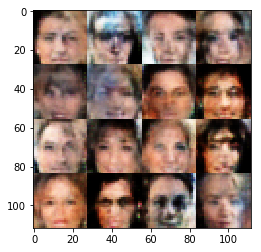

Step 1210 Epoch 1/1 Discriminator Loss: 1.1725... Generator Loss: 0.8982...
Step 1220 Epoch 1/1 Discriminator Loss: 1.2621... Generator Loss: 1.1014...
Step 1230 Epoch 1/1 Discriminator Loss: 1.0906... Generator Loss: 0.7310...
Step 1240 Epoch 1/1 Discriminator Loss: 1.3144... Generator Loss: 1.6015...
Step 1250 Epoch 1/1 Discriminator Loss: 0.4537... Generator Loss: 1.9460...
Step 1260 Epoch 1/1 Discriminator Loss: 1.7152... Generator Loss: 1.0192...
Step 1270 Epoch 1/1 Discriminator Loss: 1.5406... Generator Loss: 0.3459...
Step 1280 Epoch 1/1 Discriminator Loss: 4.5350... Generator Loss: 4.4170...
Step 1290 Epoch 1/1 Discriminator Loss: 1.2337... Generator Loss: 0.9187...
Step 1300 Epoch 1/1 Discriminator Loss: 1.5443... Generator Loss: 0.3692...


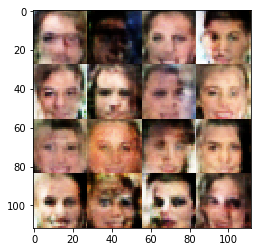

Step 1310 Epoch 1/1 Discriminator Loss: 1.3821... Generator Loss: 0.8046...
Step 1320 Epoch 1/1 Discriminator Loss: 1.4163... Generator Loss: 0.3563...
Step 1330 Epoch 1/1 Discriminator Loss: 1.5299... Generator Loss: 0.6989...
Step 1340 Epoch 1/1 Discriminator Loss: 1.3962... Generator Loss: 0.8758...
Step 1350 Epoch 1/1 Discriminator Loss: 1.2260... Generator Loss: 0.6389...
Step 1360 Epoch 1/1 Discriminator Loss: 1.4429... Generator Loss: 0.5143...
Step 1370 Epoch 1/1 Discriminator Loss: 1.4062... Generator Loss: 0.6244...
Step 1380 Epoch 1/1 Discriminator Loss: 1.4102... Generator Loss: 0.5247...
Step 1390 Epoch 1/1 Discriminator Loss: 1.5981... Generator Loss: 0.3431...
Step 1400 Epoch 1/1 Discriminator Loss: 1.3367... Generator Loss: 1.2846...


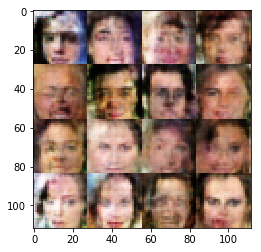

Step 1410 Epoch 1/1 Discriminator Loss: 1.1747... Generator Loss: 0.6347...
Step 1420 Epoch 1/1 Discriminator Loss: 1.1143... Generator Loss: 0.6604...
Step 1430 Epoch 1/1 Discriminator Loss: 1.7103... Generator Loss: 0.2653...
Step 1440 Epoch 1/1 Discriminator Loss: 1.1983... Generator Loss: 0.8231...
Step 1450 Epoch 1/1 Discriminator Loss: 1.1131... Generator Loss: 0.7921...
Step 1460 Epoch 1/1 Discriminator Loss: 0.9799... Generator Loss: 1.2049...
Step 1470 Epoch 1/1 Discriminator Loss: 1.1525... Generator Loss: 0.8674...
Step 1480 Epoch 1/1 Discriminator Loss: 1.8027... Generator Loss: 0.2466...
Step 1490 Epoch 1/1 Discriminator Loss: 1.3374... Generator Loss: 0.4645...
Step 1500 Epoch 1/1 Discriminator Loss: 1.1894... Generator Loss: 0.4870...


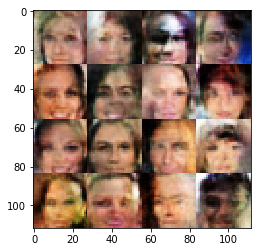

Step 1510 Epoch 1/1 Discriminator Loss: 1.3612... Generator Loss: 0.5835...
Step 1520 Epoch 1/1 Discriminator Loss: 1.6680... Generator Loss: 2.3155...
Step 1530 Epoch 1/1 Discriminator Loss: 1.2662... Generator Loss: 0.5691...
Step 1540 Epoch 1/1 Discriminator Loss: 1.4204... Generator Loss: 0.3878...
Step 1550 Epoch 1/1 Discriminator Loss: 1.3205... Generator Loss: 0.7922...
Step 1560 Epoch 1/1 Discriminator Loss: 1.3058... Generator Loss: 0.9464...
Step 1570 Epoch 1/1 Discriminator Loss: 1.2747... Generator Loss: 0.8189...
Step 1580 Epoch 1/1 Discriminator Loss: 1.0620... Generator Loss: 0.9112...
Training ended.


In [44]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.5
print_every = 10
show_every = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.